<a href="https://colab.research.google.com/github/Katabaazi-k/DS-Projects/blob/main/Customer_Segmentation_PJT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data processing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

#loading data
data = pd.read_csv('customer_segmentation.csv')
df = pd.DataFrame(data)
df

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...,...
541904,541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


handling missing CustomerID

In [2]:
print('missing customerIDs before:', df['CustomerID'].isna().sum())
df = df.dropna(subset=['CustomerID'])
print('missing customerIDs after:', df['CustomerID'].isna().sum())
df['CustomerID']= df['CustomerID'].astype(int)

missing customerIDs before: 135080
missing customerIDs after: 0


<ipython-input-2-a4a564b955d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CustomerID']= df['CustomerID'].astype(int)


In [3]:
#handling returns/negative quqntities
df = df[df['Quantity']>0]

#convert InvoiceDate to Datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

#Standardizing descriptions
df['Description'] = df['Description'].str.strip().str.upper()

In [4]:
#calculating Monetary Value
df['TotalSpend']=df['Quantity']*df['UnitPrice']

#Creating RFM table
snapshot_date = df['InvoiceDate'].max() +pd.DateOffset(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate' : lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo' : 'nunique',
    'TotalSpend' : 'sum'
}).reset_index()
rfm.columns = ['CustomerID','Recency', 'Frequency', 'Monetary']

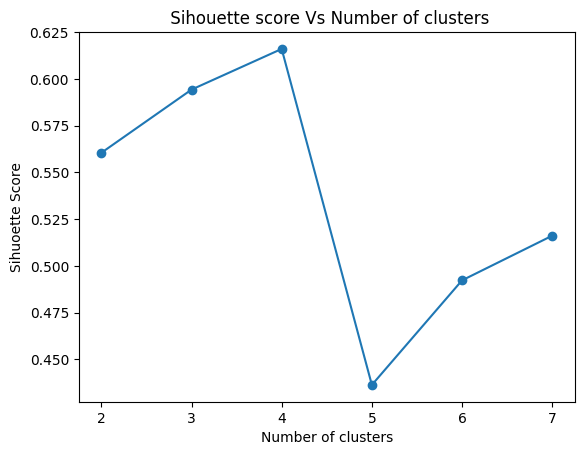

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#scaling features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency',
                                       'Frequency',
                                       'Monetary']])

#finding optimal clusters
silhouette_scores = []
for k in range (2,8):
    kmeans =KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(rfm_scaled)
    score = silhouette_score(rfm_scaled, kmeans.labels_)
    silhouette_scores.append(score)

#plotting silhouette scores
import matplotlib.pyplot as plt
plt.plot(range(2, 8), silhouette_scores,marker ='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sihuoette Score')
plt.title(' Sihouette score Vs Number of clusters')
plt.show()

#fitting final model(assuming k = 3 optimal)
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] =kmeans.fit_predict(rfm_scaled)

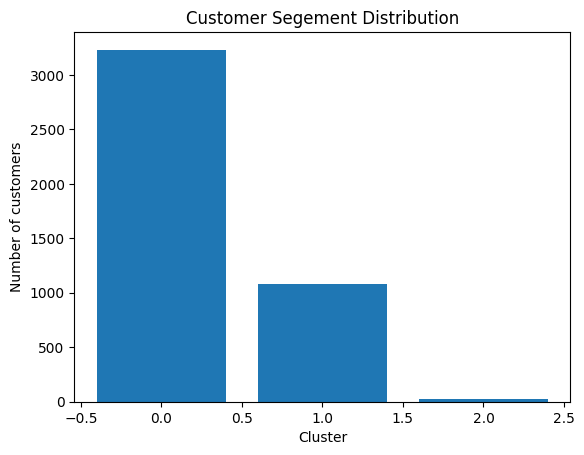

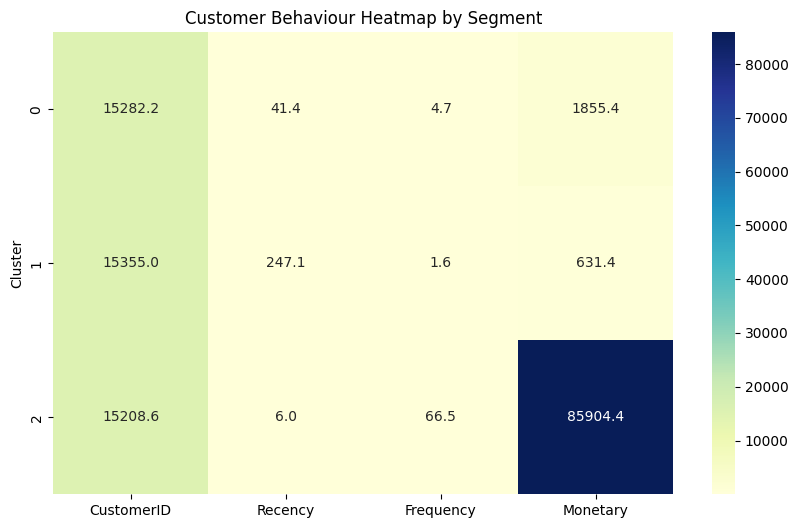

In [6]:
#Cluster Distrubution
cluster_counts = rfm['Cluster'].value_counts().sort_index()
plt.bar(cluster_counts.index, cluster_counts.values)
plt.title('Customer Segement Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of customers')
plt.show()

#Behavior heatmap
import seaborn as sns
cluster_means = rfm.groupby('Cluster').mean()
plt.figure(figsize = (10,6))
sns.heatmap(cluster_means, annot =  True, cmap ="YlGnBu", fmt = '.1f')
plt.title('Customer Behaviour Heatmap by Segment')
plt.show()